In [25]:
from bs4 import BeautifulSoup
import urllib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import gmaps
import gmaps.datasets

main_url = "http://207.251.86.229/nyc-links-cams/LinkSpeedQuery.txt"
api_key = ""

In [15]:
### !jupyter nbextension enable --py --sys-prefix gmaps

In [16]:
def getsoup(url):
    r = urllib.urlopen(url).read()
    soup = BeautifulSoup(r,'lxml')
    return soup
def crawl(url):
    soup = getsoup(url)
    content = soup.text
    data = [x.split('\t') for x in content.split('\n')]
    df = pd.DataFrame(data,columns =data[0])
    df = df.applymap(lambda x: str(x)[1:-1].replace('"', ''))
    df.columns = df.iloc[0]
    df = df[1:-1] 
    return df

def toFloat(df,cols):
    for col in cols:
        df[col] = df[col].astype(float) 
    return df

def update(keyword=[""]):
    batch = crawl(main_url)
    batch = toFloat(batch,['Speed',"TravelTime","linkId","Transcom_id"])
    data = pd.DataFrame()
    for x in keyword:
        data= data.append(batch[batch['linkName'].str.lower().str.contains(x.lower())])
    data = data[data['Speed']>0]
    return data

def compile_location_list(df):
    out = pd.DataFrame()
    for i in range(data.shape[0]):
        d = pd.DataFrame([a for a in df.linkPoints.iloc[i].split(' ')],columns = ['Location'])
        d['TravelTime'] = df.TravelTime.iloc[i]
        out = out.append(d)
    out = out[out.Location.str.contains(",") == True]
    out = out[out.Location.str.count('.')>=15]
    out = out[out.Location.str.count('.')<=25]
    return out

def transform_location_list(df):
    return [[float(a) if is_number(a) else -1000 for a in x.split(",")]for x in df]

def generate_traffic(fig,api,data):
    route_data = compile_location_list(data)
    route = transform_location_list(route_data.Location)
    gmaps.configure(api_key=api)
    #normalize
    route_data.TravelTime = route_data.TravelTime / (route_data.TravelTime.max()-route_data.TravelTime.min())
    fig.add_layer(gmaps.heatmap_layer(route,weights=route_data.TravelTime,max_intensity = 1,point_radius = 20.0))
    fig.add_layer(gmaps.traffic_layer())
    return fig

def isFloat(data):
    if re.match("^\d+?\.\d+?$", data) is None:
        return False
    return True

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
    return False

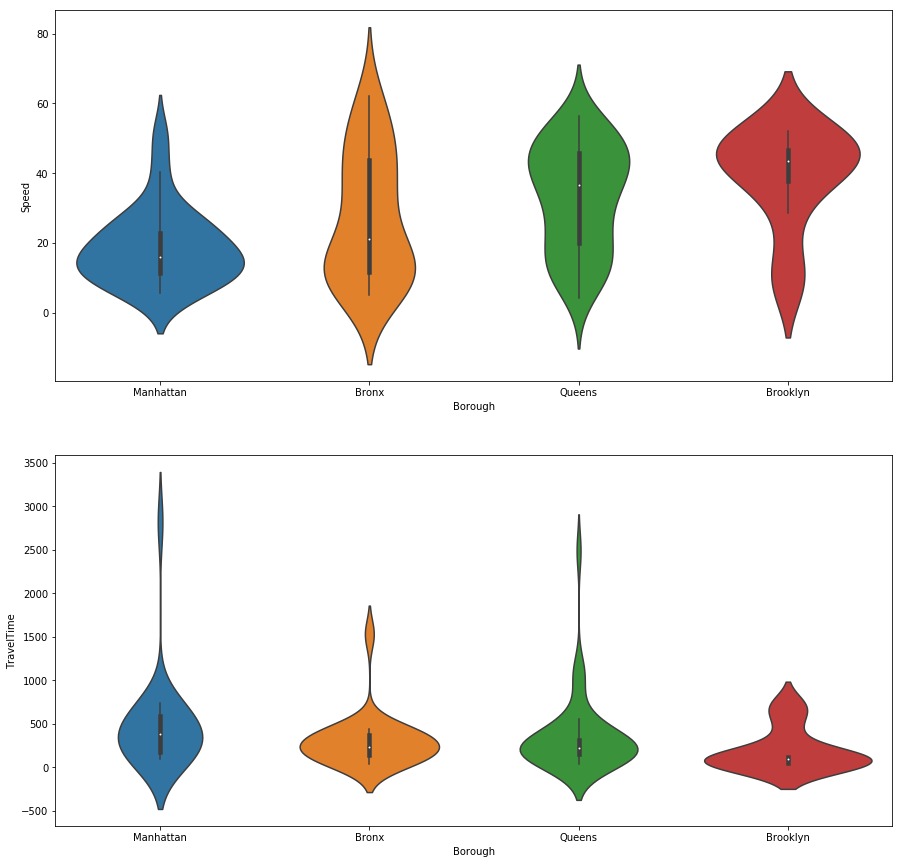

In [17]:
data = update()
data = data[(data.Borough != 'Staten Island') & (data.Borough !='Staten island')]
f, (ax1, ax2) = plt.subplots(2)
f.set_figheight(15)
f.set_figwidth(15)
sns.violinplot(data.Borough,data.Speed,ax=ax1)
sns.violinplot(data.Borough,data.TravelTime,ax=ax2)
plt.show()

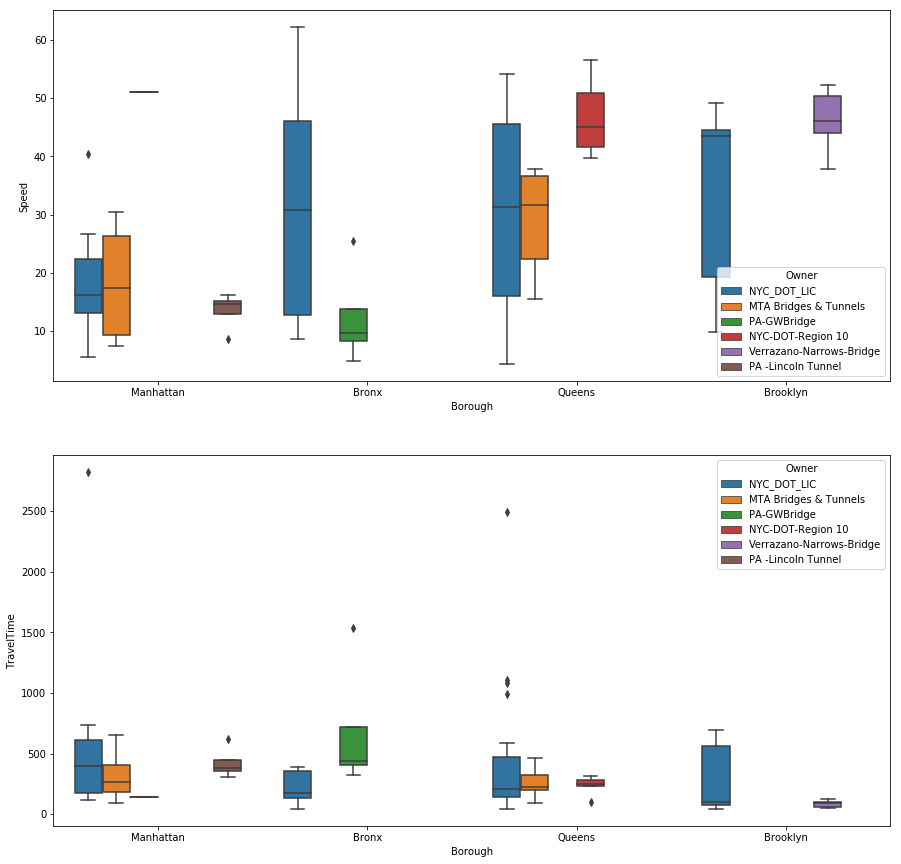

In [18]:
data = update()
data = data[(data.Borough != 'Staten Island') & (data.Borough !='Staten island')]
f, (ax1, ax2) = plt.subplots(2)
f.set_figheight(15)
f.set_figwidth(15)
sns.boxplot(data.Borough,data.Speed,ax=ax1,hue=data.Owner)
sns.boxplot(data.Borough,data.TravelTime,ax=ax2,hue=data.Owner)
plt.show()

In [27]:
data = data[data.Borough=='Queens']
new_york_coordinates = (40.661, -73.79)
fig = gmaps.figure(center=new_york_coordinates, zoom_level=10)
fig = generate_traffic(fig,api_key,data)
fig

A Jupyter Widget

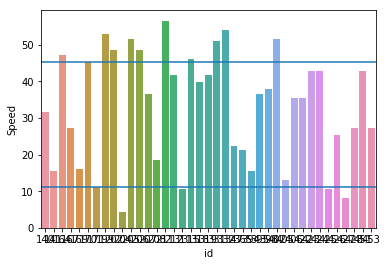

In [20]:
#need to identify which entrance is important
ax= sns.barplot(data.id,data.Speed,data= data)
[ax.axhline(x) for x in data[data.linkName.str.contains("JFK")]['Speed']]
plt.show()

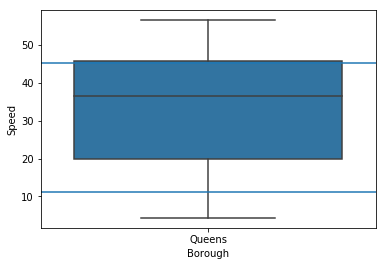

In [22]:
ax = sns.boxplot(data.Borough,data.Speed)
[ax.axhline(x) for x in data[data.linkName.str.contains("JFK")]['Speed']]
# q75, q25 = np.percentile(data.Speed, [75 ,25])
# iqr = q75 - q25
# l = q25 - (iqr*1.5)
# u = q75 + (iqr*1.5)
# ax.axhline(l)
# ax.axhline(u)
plt.show()